In [19]:
# GENERIC LIBRARIES #####
from matplotlib import pyplot as plt # type: ignore
import numpy as np
import emcee

#### DATA TREATMENT ####
import pandas as pd

######## FIT LIBRARIES ####
import lmfit
from lmfit import Parameters, Parameter


###### INTERPOLATION LIBRARIES #####
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.optimize import fsolve, brentq
from scipy.interpolate import UnivariateSpline


from scipy.optimize import curve_fit
from scipy.stats import chisquare
from scipy.stats import chi2_contingency


import scipy.integrate as integrate
import scipy.special as special


#########CORNER ##########
import corner
#import pygtc



###############################
from lmfit.model import save_modelresult
from lmfit.model import load_modelresult

#other useful features
from inspect import signature
from numpy import log10
from numpy import log
from numpy import pi
from numpy import sqrt
from scipy.optimize import minimize
from numpy import sqrt, pi, sin, cos, log, exp, euler_gamma
from scipy.special import kn, gamma, loggamma
from scipy.interpolate import RectBivariateSpline
#from IPython.display import display, Math
#plt.rcParams['text.usetex'] = True
from scipy.special import hyp2f1
from numpy import exp
import warnings
#from pathos.multiprocessing import ProcessingPool as Pool

#from scipy.optimize import curve_fit
#from scipy.integrate import quad

#import seaborn as sns
#import matplotlib.patches as mpatches
#%matplotlib inline
#%config InlineBackend.figure_format = 'svg'


In [20]:
#Useful constants in SI

hbar = 1.054571817e-34 #reduced Planck constant
e = 1.60217662e-19 #elementary charge
c0 = 2.99792458e8 #speed of light in vacuum
G = 6.67430e-11 #Gravitational constant
#Solar mass
sm = 1.98847e30
#Parsec
pc = 3.0856775814913673e16


#length scale of natural units

evm = hbar*c0/e
#time scale of natural units
evs = hbar/e
#mass scale of natural units
evkg = e/c0**2



#Hubble constant (km/s/Mpc)
H = 67.8

#Reduced Hubble constant
h = H/100

#H = 70

om = 0.284 # matter density parameter

pcrit = 3*(H*1000/(1e6*pc))**2/(8*np.pi*G) #cosmological matter density

#pcrit = 128.2 * sm / ((1000*pc)**3) #Fraternali critical density

pom = om*pcrit #cosmological matter density

#Relevant quantities in natural units (hbar = 1, c0 = 1)

#typical axion mass (eV)
ma=1e-22

#gravitational constant
evG = G*e**2/(c0**5*hbar)
#Planck mass
evMpl = 1/sqrt(evG)
#Hubble constant
evH = H*1000/(pc*1e6)*hbar/e
#Cosmological critical density
rc = 3*evH**2/(8*np.pi*evG)
#NFW characteristic radius
#evrs = rs/evm
#Solar mass
evsm = sm/evkg
#Parsec
evpc=pc/evm

evpom = pom*(evm**3)/evkg #cosmological matter density

#Some general formatting settings for plotting
plt.style.use('default')
#[Note: if you encounter an error, ensure the Latex package is installed in your computer
#(or erase the line below)]
#pl.rc('text', usetex=True)
#plt.rc('font', family='serif')
size = 25
width=1
dash=(10,2)
i10=-1


In [21]:
#optimizer that looks for a finite-value log-probability optimum
#It works by perturbing the initial guess with sigma normal
#fluctuations (sig*100 is the percentage relative to the mean), 
#it then uses the scipy optimizer to find finite local 
#maxima of the probability and selects the best of those to get
# an estimate of the global one


def optimizer(name, lpost, init, ndim, stps, sig, period = 100):
    
        params = []
        
        nlprobs = []
    
        init0 = init
        
        
        filname = 'Data.dat'
        
        V   = np.loadtxt(filname, usecols = 1)
        VL  = np.loadtxt(filname, usecols = 2)
        VR  = np.loadtxt(filname, usecols = 3)
        EV  = V-VL
        S   = np.loadtxt(filname, usecols = 4)
        SD  = np.loadtxt(filname, usecols = 5)
        SU  = np.loadtxt(filname, usecols = 6)
        ES  = S-SD

       
        
        nll = lambda *args: - lpost(*args)
        

        for t in range(3):
            
            sig *= 2**(t)
        
            for i in range(stps):

                if i%period == 0:

                    init = init0

                rand = np.random.randn(ndim)

                for j in range(ndim):
                        rand[j] *= sig*init[j]

             
                

                soln = minimize(nll, init, args=(V, S, ES, EV))

                init = soln.x

                nlpr = nll(init, V, S, ES, EV);

                if np.isfinite(nlpr): 

                          params.append(init)
                          nlprobs.append(nlpr)

       
        if len(nlprobs) == 0:
            print("No viable log-probability optimisation found:")
            print( " ")
            print(init)
            return init0
        
        mlprob = np.inf
        
        for k in range(len(nlprobs)):
            if nlprobs[k] < mlprob:
                mlprob = nlprobs[k]
                init = params[k]
                
        for n in range(len(nlprobs)):
            if nlprobs[n] < 1.25*mlprob and max(abs(params[n] - init)) > 1:
                print("Alternative optimum at ", params[n])     
                
        print("Log-probability optimum found:")
        print( " ")
        print(init, "[log-prob. = ", -mlprob, "]")
        return init

In [22]:


c = 3e+5 #Light speed in km/s
G = 4.3e-3 # In units of pc/Ms * (km/s)^2
h = 0.674
rho_c = 2.7754e-7*h**2 # In units of Ms/Mpc-3
GeVtocm2 = (1/5.06e13)**2 # cm^2
GeVtog = (1/1.78e-24)

"""
///////////// Plot Settings ///////////////


"""
#Global Setting

#sns.set_style('ticks') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
plt.rc('axes', linewidth=1.25 )   # width of the frame
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('font', size=14)          # controls default text sizes

#Latex rendering
#plt.rc('font', **{'family': 'serif', 'serif': ['Modern Computer']})
#plt.rc('text', usetex=True)
#plt.rc('font', weight='bold')

#Colors:

RegionAlpha = 0.5
MainColor1 = (0.580,0.706,0.231)
MainColor2 = (0.650,0.110,0.192)
BackgroundColor1 = (0.275,0.419,0.247)
BackgroundColor2 = (0.467,0.137,0.184)
Gray1 = (0.337,0.352,0.360)
Gray2 = (0.694,0.698,0.690)

#convertion factor
fc = GeVtocm2*GeVtog

## Target function

Siempre la funcion para el ajuste es sigmav

In [23]:
# Viscocity xsec

def sigmav(mchi, mphi, V):
    alphax = 0.007
    w  = 300*(mphi/(10))*(10/(mchi))
    st = (275.73)*(alphax/0.01)**2*(mchi/10.0)*(10.0/(mphi))**(4)
    sv = 6*st*(w**6/(V**6))*((2+V**2/(w**2))*np.log(1+V**2/(w**2))-2*V**2/w**2)
    return sv

def omega(mchi, mphi):
    w  = 300*(mphi/(10))*(10/(mchi))
    return w


def logp(lmchi, lalpha, V):
    if -10 < lmchi < 10 and -10 < lalpha < 10:
        return 0.0
    return -np.inf    

In [24]:


def GOPT(name, init, nwalkers = 48, 
           steps = 2000, burn = 0, opstps = 1000, sig = 0.1, sigp = 0.1):

   
       
        
        #DM only rotation curve
        def smodel(theta, V):
            param = np.copy(theta)
            param = 10**param
            return sigmav(*param,V)

        


        #log-prior
        def lprior(theta, V):
            return logp(*theta, V)

        
        
            

        #log-likelihood function
        def llhood(theta, V, S, ES, EV):
            #angular dependence
            param = np.copy(theta)
            model = smodel(theta, V);
            sigma2 = ES**2
            return -0.5*np.sum((S - model)**2 / sigma2)


        #log-posterior function
        def lpost(theta, V, S, ES, EV):
        
            lp = lprior(theta, V);

            #discards parameters not satisfying the log-prior conditions
            if not np.isfinite(lp): 
                return -np.inf

            llh = llhood(theta, V, S, ES, EV);

            #discards mathematically unsound parameters (those yielding square roots of negative numbers etc.)
            if np.any(np.isnan(lp + llh)) == True: 

                return -np.inf

            return lp + llh
        
        

        filname = 'Data.dat'
        V   = np.loadtxt(filname, usecols = 1)
        VL  = np.loadtxt(filname, usecols = 2)
        VR  = np.loadtxt(filname, usecols = 3)
        EV  = V-VL
        S   = np.loadtxt(filname, usecols = 4)
        SD  = np.loadtxt(filname, usecols = 5)
        SU  = np.loadtxt(filname, usecols = 6)
        ES  = S-SD
        
        ndim = 2
        n = len(S)    
        rand = np.random.randn(nwalkers, ndim)

        #This avoids error messages when the parameters yield mathematically unsound results (square roots of 
        #negative numbers etc.), these will be discarded from the parameter space, but are computed so #
        #that they can be evaluated
        with warnings.catch_warnings(): 
            warnings.simplefilter('ignore')
            #"refined" initial guess (in case the initial one has divergent log-posterior probability or is 
            #sub-optimal with respect to the log-posterior probability)
            print( " ")
            print("Result for initial maximum log-posterior estimate:")
            print( " ")
            init = optimizer(name, lpost, init, ndim, opstps, sig)
            linit = lpost(init, V, S, ES, EV)
            thresh= log(100)
            for val in rand:
                for i in range(ndim):
                    val[i] *= sigp*init[i]
                ipval =  init + val 
                lpval = lpost(ipval, V, S, ES, EV)
                while linit - lpval > thresh:
                    val *= 0.5
                    ipval = init + val
                    lpval = lpost(ipval, V, S, ES, EV)


            pos = init + rand;

            filename = str(name + "_mcmc_chain")


  #  def lpostg(theta):
   #         return lpost(theta, R, mgas, rst, rgas, mst0, errmst0, Vr, errVr, Va, errVa)

            max_n = steps + burn
            min_n = 2*burn

            sampler = emcee.EnsembleSampler(nwalkers, ndim, lpost,
                        args = (V, S, ES, EV),
                                           moves=[
    (emcee.moves.DEMove(), 0.8),
    (emcee.moves.DESnookerMove(), 0.2),
]);

            # We'll track how the average autocorrelation time estimate changes
            index = 0
            autocorr = np.empty(max_n)

            # This will be useful to testing convergence
            old_tau = np.inf

            # Now we'll sample for up to max_n steps
            for sample in sampler.sample(pos, iterations=max_n, progress=True):
                # Only check convergence every 100 steps
                if sampler.iteration % 100:
                    continue

                # Compute the autocorrelation time so far
                # Using tol=0 means that we'll always get an estimate even
                # if it isn't trustworthy
                tau = sampler.get_autocorr_time(tol=0)
                autocorr[index] = np.mean(tau)
                index += 1

                # Check convergence
                converged = np.all((tau * 100) < sampler.iteration)
                converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
                converged &= np.all(min_n <= sampler.iteration)
                if converged:
                    break
                old_tau = tau
            

            tau = sampler.get_autocorr_time(quiet = True)
            print( " ")
            print('Autocorrelation time 1 = ', tau)
            print( " ")
            print("Mean acceptance fraction 1 = ", np.mean(sampler.acceptance_fraction))
            print( " ")
            flat_samples = sampler.get_chain(discard=burn, flat=True)

            logs = sampler.get_log_prob(discard=burn, flat=True)

            ind = logs.argsort()

            sorsam = flat_samples[ind]

            maxlp = sorsam[-1]
            
            print("Global optimum from initial chain: ")
            print(" ")
            print(maxlp, "[log-prob. = ", max(logs) ,"]")
            print(" ")
            #return [maxlp, max(tau)]
            return maxlp
           

In [37]:
# Main Function to perform an optimized Markov Chain Montecarlo Fit,
# It requires: 
# init: Initial guess for the parameters
# savechain: 
# nwalkers: Number of MCMC walkers.
# steps: Number of MCMC steps.
# burn: Number of burn-in steps.
# maxstps: Maximum number of steps for the initial estimation.
# opstps: Number of steps for the initial estimation.
# sig: Significance level.
# folder: Folder to save the output.
# sigp: Significance level for initial estimation.
# err: Whether to compute errors.

def GGMCMC(init, savechain = False, nwalkers = 48, 
           steps = 10000, burn = 1000, maxstps = 2000, opstps = 10000, sig = 0.1, folder = None, sigp = 0.1, err = False):
   
    #What is doing this variable?
    name = "xsecvalpha" 
        
    #Name of some file
    filename = 'Data.dat'

    #DM only rotation curve (???). Theta refers to the parameters of the fit
    def smodel(theta, V):
        param = np.copy(theta)
        param = 10**param
        return sigmav(*param,V)
    

    #define log-prior
    def lprior(theta, V):
        return logp(*theta, V)

    #define log-likelihood function
    def llhood(theta, V, S, ES, EV):
        #angular dependence
        param = np.copy(theta)
        model = smodel(theta, V)
        sigma2 = ES**2
        return -0.5*np.sum((S - model)**2 / sigma2)
        
    
    #log-posterior function
            
    def lpost(theta, V, S, ES, EV):
    
        lp = lprior(theta, V);

        #discards parameters not satisfying the log-prior conditions
        if not np.isfinite(lp): 
            return -np.inf

        llh = llhood(theta, V, S, ES, EV);

        #discards mathematically unsound parameters (those yielding square roots of negative numbers etc.)
        if np.any(np.isnan(lp + llh)) == True: 

            return -np.inf

        return lp + llh
    
    """         

        V   = np.loadtxt(filname, usecols = 1)
        VL  = np.loadtxt(filname, usecols = 2)
        VR  = np.loadtxt(filname, usecols = 3)
        EV  = V-VL
        S   = np.loadtxt(filname, usecols = 4)
        SD  = np.loadtxt(filname, usecols = 5)
        SU  = np.loadtxt(filname, usecols = 6)
        ES  = S-SD
        

        n = len(S)
        ndim = 2
        rand = np.random.randn(nwalkers, ndim)

        

        #This avoids error messages when the parameters yield mathematically unsound results (square roots of 
        #negative numbers etc.), these will be discarded from the parameter space, but are computed so #
        #that they can be evaluated
        with warnings.catch_warnings(): 
            warnings.simplefilter('ignore')
            #"refined" initial guess (in case the initial one has divergent log-posterior probability or is 
            #sub-optimal with respect to the log-posterior probability)
            print( " ")
            print("Result for maximum log-posterior estimate:")
            print( " ")
            
            init = GOPT(name, init, nwalkers = 48, 
            steps = maxstps, burn = 0, opstps = opstps, sig = 0.1, sigp = 0.1)
            linit = lpost(init, V, S, ES, EV)
            thresh= log(100)
            
            for val in rand:
                for i in range(ndim):
                    val[i] *= sigp*init[i]
                ipval =  init + val 
                lpval = lpost(ipval, V, S, ES, EV)
                while linit - lpval > thresh:
                    val *= 0.5
                    ipval = init + val
                    lpval = lpost(ipval, V, S, ES, EV)


            pos = init + rand;

            filename = str(name + "_mcmc_chain")
            
            conv = False

            #if savechain == True:
                 #   print("Chain saved")
                #    backend = emcee.backends.HDFBackend(filename)
                  #  backend.reset(nwalkers, ndim)

                  #  sampler = emcee.EnsembleSampler(nwalkers, ndim, lpost, backend = backend,\
                  #                                  args = (R, mgas, rst, rgas, mst0, errmst0, Vr, errVr, Va, errVa),
                  #                                 moves=[
            #(emcee.moves.DEMove(), 0.8),
            #(emcee.moves.DESnookerMove(), 0.2),
       # ]);

            #else:
                    
        max_n = steps 
        min_n = 2*burn

        sampler = emcee.EnsembleSampler(nwalkers, ndim, lpost,
                    args = (V, S, ES, EV),
                    moves=[ 
                    (emcee.moves.DEMove(), 0.8),
                    (emcee.moves.DESnookerMove(), 0.2),
                    ]);

        # We'll track how the average autocorrelation time estimate changes
        #index = 0
        #autocorr = np.empty(max_n)

        # This will be useful to testing convergence
        old_tau = np.inf
        
        taus = []

        # Now we'll sample for up to max_n steps
        for sample in sampler.sample(pos, iterations=max_n, progress=True):
                # Only check convergence every 100 steps
                if sampler.iteration % 100:
                    continue

                # Compute the autocorrelation time so far
                # Using tol=0 means that we'll always get an estimate even
                # if it isn't trustworthy
                tau = sampler.get_autocorr_time(tol=0)
                taus.append(np.mean(tau))
                #autocorr[index] = np.mean(tau)
                #index += 1

                # Check convergence
                converged = np.all((tau * 100) < sampler.iteration)
                converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
                converged &= np.all(min_n <= sampler.iteration)
                if converged:
                    burn = int(sampler.iteration/2)
                    conv = True
                    break
                old_tau = tau



    
        if conv == False:
                  burn = int(steps/2)
                 
        stepa = np.linspace(1, len(taus), len(taus))*100
        taus = np.array(taus)

        plt.plot(stepa, stepa/100, label = r'$\hat{\tau}= N/100$')

        #plt.plot(stepa, stepa/50, label = r'$\hat{\tau} = N/50$')

        plt.legend(fontsize = 0.5*size)

        plt.title(r'Mean Autocorrelation Time vs Steps', fontsize = 0.5*size)

        plt.xlabel(r'$N$', fontsize = 0.5*size)
        
        plt.ylabel(r'$\hat{\tau}$', fontsize = 0.5*size)

        plt.plot(stepa, taus)
        
        if folder == None:
            plt.savefig(str("Parameters/" + name + "_tau.pdf"))
        
        plt.show()

        print("Burn-in period = ", burn," steps")
        tau = sampler.get_autocorr_time(quiet = True)

        print( " ")
        print('Autocorrelation time = ', tau)
        print( " ")
        print("Mean acceptance fraction = ", np.mean(sampler.acceptance_fraction))
        print( " ")

        flat_samples = sampler.get_chain(discard=burn, flat=True)

        low = []

        high = []

        med = []

        maxr = []

        minr = []

        min95 = []

        max95 = []
        
        labels = [r'$m_{\chi}$ [GeV]',r'$m_{\phi}$ [MeV]',r'$\alpha_{X}$']
        labels1 = [r'$m_{\chi}$',r'$m_{\phi}$',r'$\alpha_{X}$']
        print( " ")
        print("Medians within 65% of the sample:")
        print( " ")
        for i in range(ndim):
            mcmc = np.percentile(flat_samples[:, i], [16, 50, 84, 0.1, 99.9, 2.5, 97.5])
            q = np.diff(mcmc)
            low.append(mcmc[1] - q[0])
            high.append(mcmc[1] + q[1])
            med.append(mcmc[1])
            minr.append(mcmc[3])
            maxr.append(mcmc[4])
            min95.append(mcmc[5])
            max95.append(mcmc[6])
            print( " ")
            print(labels[i]," ", mcmc[1], " ", q[0], " ", q[1])
            print( " ")

        logs = sampler.get_log_prob(discard=burn, flat=True)

        ind = logs.argsort()

        sorsam = flat_samples[ind]

        maxlp = sorsam[-1]
        lp32 = sorsam[int(0.32*len(sorsam))]
        minlp = sorsam[0]
        print(" ")
        print("Maximum posterior values = ", maxlp)
        print(" ")
        print("32 percentile posterior values = ", lp32)
        print(" ")
        print("Minimum posterior values = ", minlp)

        sor68 = sorsam[int(0.32*len(sorsam) - 1):]
        minres = np.inf
        maxres = -np.inf
        
        sor95 = sorsam[:int(0.32*len(sorsam))]

#         mint = None

#         maxt = None

        #Normalised residuals
        def normres(theta, V, S, ES, EV):
            param = np.copy(theta)
            model = smodel(*param, V);
            sigma2 = ES**2
            return np.sum((model - S) / sigma2)



        fsan = np.copy(flat_samples)

        for i in range(len(fsan)):
                fsan[i]= 10**fsan[i]

        maxsan = np.copy(maxlp)




        #corner plots
        plt.rcParams['text.usetex'] = True

        fig = corner.corner(fsan, labels=labels1, truths=maxsan, fontsize = 1.4*size,\
        quantiles = (0.16, 0.5, 0.84), color ='royalblue', \
        show_titles=True, title_fmt='.2f', use_math_text=True, title_kwargs=dict(fontsize=16));
         
        for ax in fig.get_axes():  
            ax.tick_params(axis='both', labelsize=16)
            ax.xaxis.label.set_size(18)
            ax.yaxis.label.set_size(18)
            ax.xaxis.label.set_family('serif')
            ax.yaxis.label.set_family('serif')
            for axis in ['top','bottom','left','right']:
                ax.spines[axis].set_linewidth(1.75)
        
        #NAME = name.upper()
        #plt.suptitle("MW ",fontsize=24, color='deepskyblue', x=0.7, y=0.9)
    
    
        if folder == None:
            namec = str("Corner Plots/" + name + "_corner.pdf")
            plt.savefig(namec)
        plt.show()

        n = len(S)    

        low = np.array(low)
        high = np.array(high)
        med = np.array(med)
        maxr = np.array(maxr)
        minr = np.array(minr)
        print( " ")
        print("99.9 parameter percentile values = ", maxr)
        print( " ")
        print("0.1 parameter percentile values = ", minr)
        print( " ")
        print("97.5 parameter percentile values = ", max95)
        print( " ")
        print("2.5 parameter percentile values = ", min95)


        #Chi-square function
        def chi2(theta, V, S, ES, EV):
            param = np.copy(theta)
            model = smodel(theta, V);
            sigma2 = ES**2
            return np.sum((S-model)**2 / sigma2)

#         def rllhood(theta, R, Vobs, Vgas, Vdisk, Vbul, errV):

#             count = 0

#             for i in range(len(theta)):
#                 if minr[i]<= theta[i] <= maxr[i]:
#                     count += 1
#             if count == len(theta):
#                 return llhood(theta, R, Vobs, Vgas, Vdisk, Vbul, errV)

#             else:
#                 return -np.inf 

        valhoods = np.ones(len(flat_samples))
        for i in range(len(flat_samples)):
            valhoods[i] = llhood(flat_samples[i], V, S, ES, EV)    

        lind = valhoods.argsort()
        lsorsam = flat_samples[ind]

        print(" ")
        chipost = chi2(maxlp, V, S, ES, EV)/(n - ndim )
        print("Reduced chi-square of maximum posterior = ", chipost)
        print(" ")  
        print("Log-posterior of maximum posterior = ",\
              lpost(maxlp, V, S, ES, EV))
        print(" ")       
        print("Reduced chi-square of 32 percentile posterior = ",\
              chi2(lp32, V, S, ES, EV)/(n - ndim ))
        print(" ") 
        print("Log-posterior of 32 percentile posterior = ",\
              lpost(lp32, V, S, ES, EV))
        print(" ")
        print("Reduced chi-square of minimum posterior = ",\
              chi2(minlp, V, S, ES, EV)/(n - ndim ))
        print(" ") 
        print("Log-posterior of minimum posterior = ",\
              lpost(minlp, V, S, ES, EV))  
        print(" ")
        print("Log-posterior of 2.5 percentile parameters = ",\
              lpost(min95, V, S, ES, EV))  
        print(" ")
        print("Log-posterior of 97.5 percentile parameters = ",\
              lpost(max95, V, S, ES, EV))  
        print(" ")

#         print("Reduced chi-square of 32 percentile min. norm. residuals = ",\
#               chi2(mint, R, Vr, errVr, Va, errVa)/(n - ndim ))
#         print(" ") 
#         print("Log-posterior of 32 percentile min. norm. residuals = ",\
#               lpost(mint, R, mgas, rst, rgas, mst0, errmst0, Vr, errVr, Va, errVa))   
#         print(" ")
#         print("Reduced chi-square of 32 percentile max. norm. residuals  = ",\
#               chi2(maxt, R, Vr, errVr, Va, errVa)/(n - ndim ))
#         print(" ") 
#         print("Log-posterior of 32 percentile max. norm. residuals = ",\
#               lpost(maxt, R, mgas, rst, rgas, mst0, errmst0, Vr, errVr, Va, errVa))   

        mle = lsorsam[-1]
        print( " ")
        print("MLE parameters = ", mle)
        #init2 = optimizer(name, rllhood, med, ndim, opstps, sig)

        print( " ")
        rchi =  chi2(mle, V, S, ES, EV)/(n - ndim )
        print("Reduced chi-square of MLE = ", rchi)
        print(" ") 
        print("Log-posterior of MLE = ",\
              lpost(mle, V, S, ES, EV))
        print( " ")
        bic = chi2(mle, V, S, ES, EV) + ndim*log(n)
        print("BIC (up to a constant, at MLE) = ", bic)
        print( " ")
        print("Reduced chi-square of 0.1 percentile parameters = ",\
              chi2(minr, V, S, ES, EV)/(n - ndim ))
        print("Reduced chi-square of 2.5 percentile parameters = ",\
              chi2(min95, V, S, ES, EV)/(n - ndim ))

        print( " ")
        print("Reduced chi-square of 16 percentile parameters = ",\
              chi2(low, V, S, ES, EV)/(n - ndim ))
        print( " ")
        print("Reduced chi-square of 50 percentile (median) = ",\
              chi2(med, V, S, ES, EV)/(n - ndim ))
        print(" ") 
        print("Log-poslterior of 50 percentile (median) = ",\
              lpost(med, V, S, ES, EV))
        print(" ")
        print("Reduced chi-square of 84 percentile parameters = ",\
              chi2(high, V, S, ES, EV)/(n - ndim ))
        print( " ")
        print("Reduced chi-square of 97.5 percentile parameters = ",\
              chi2(max95, V, S, ES, EV)/(n - ndim ))
        print( " ")
        print("Reduced chi-square of 99.9 percentile parameters = ",\
              chi2(maxr, V, S, ES, EV)/(n - ndim ))
        print( " ")

        #rotation curves
        fig, ax = plt.subplots(figsize=(10,8))
        
        
        filname1 = 'Data_1.dat'
        V1   = np.loadtxt(filname1, usecols = 1)
        VL1  = np.loadtxt(filname1, usecols = 2)
        VR1  = np.loadtxt(filname1, usecols = 3)
        EV1  = V1-VL1
        S1   = np.loadtxt(filname1, usecols = 4)
        SD1  = np.loadtxt(filname1, usecols = 5)
        SU1  = np.loadtxt(filname1, usecols = 6)
        ES1  = S1-SD1
        
        ax.errorbar(V1, S1, yerr = ES1, xerr = EV1, capsize=4, capthick=1.0, color='gray',\
                    fmt="o",markersize=10.5,linewidth=0.5,mec='darkgreen')


        if err == True:


            maxvs_c = list(np.ones(n))

            minvs_c = list(np.ones(n))

            maxvs = np.ones(n)*-np.inf

            minvs = np.ones(n)*np.inf

            for theta in sor68:

                vth = smodel(theta,  V)

                for i in range(n):
                    if vth[i] > maxvs[i]:
                        maxvs[i] = vth[i]
                        maxvs_c[i] = theta

                    if vth[i] < minvs[i]:
                        minvs[i] = vth[i]
                        minvs_c[i] = theta
                        
                        
            maxvs95_c = list(np.ones(n))

            minvs95_c = list(np.ones(n))  
            
            maxvs95 = np.ones(n)*-np.inf

            minvs95 = np.ones(n)*np.inf
            
            for theta in sor95:

                vth = smodel(theta,  V)

                for i in range(n):
                    if vth[i] > maxvs95[i]:
                        maxvs95[i] = vth[i]
                        maxvs95_c[i] = theta

                    if vth[i] < minvs95[i]:
                        minvs95[i] = vth[i]
                        minvs95_c[i] = theta
                        
                        
            for i in range(n):
                    
                    if maxvs95[i] < maxvs[i]:

                        maxvs95[i] = maxvs[i]

                        maxvs95_c[i] = maxvs_c[i]


                    if minvs95[i] > minvs[i]:

                        minvs95[i] = minvs[i]

                        minvs95_c[i] = minvs_c[i]            


                    
           


        #plt.fill_between(R, vmodel(*mint, R, Vgas, Vdisk, Vbul), vmodel(*maxt, R, Vgas, Vdisk, Vbul),\
                       #  color='red', alpha=0.2, zorder=0)

#                 len68 = len(sor68)
#                 for i in range(100):
#                     theta = sor68[np.random.randint(1, len68)]
#                     ax.plot(R, vmodel(*theta, R, Vgas, Vdisk, Vbul), color='red', alpha=0.2, linewidth = 1)
        
        
       

        VX = np.linspace(8, 120, 10000)

        

        #SDM = smodel(maxlp, VX)
        SDM = smodel(med,VX)
        SDMU = smodel(high,VX)
        SDMD = smodel(low,VX)
        
        
        
        ax.plot(VX, SDM, label= 'best-fit', ls='--', linewidth=2.5, color = "salmon")
        ax.plot(VX, SDMU, linewidth=2.5, color = "salmon")
        ax.plot(VX, SDMD, linewidth=2.5, color = "salmon")

        plt.fill_between(VX, SDMU, SDMD,color='red', alpha=0.1, zorder=0)
        
        plt.xscale('log')
        plt.yscale('log')
        
        plt.xlim(8,120)
        plt.ylim(8,420)
        
        ax.legend(fontsize = size)
        plt.ylabel(r'$\sigma/m_{\chi}$ $[$ cm$^{2}$ $/$ g $]$ ', fontsize = size)
        plt.xlabel(r'$v$ $[$ km$/$s $]$ ', fontsize = size)
        plt.xticks(fontsize = 0.9*size)
        plt.yticks(fontsize = 0.9*size)
        ax.tick_params('both', length=8.5, width=1.7, which='major', direction="in")
        ax.tick_params('both', length=5, width=1.4, which='minor', direction="in")
        axx = ax.secondary_yaxis("right");
        axy = ax.secondary_xaxis("top");
        axx.tick_params('both', length=8.5, width=1.7, which='major', direction="in", labelright=False, labeltop=False)
        axx.tick_params('both', length=5, width=1.4, which='minor', direction="in")
        axy.tick_params('both', length=8.5, width=1.7, which='major', direction="in", labelright=False, labeltop=False)
        axy.tick_params('both', length=5, width=1.4, which='minor', direction="in")
        plt.legend(fontsize = size*0.7, frameon=False)
        
        
        #ax.annotate(r'$\alpha=0.01$', xy = (10,15), xytext=(10, 15), fontsize = size)
          
        
        #NAME = name.upper()
        #plt.title(r'$\sigma$ vs v', fontsize = size)
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(1.75)
       


        

            
        oar = np.linspace(1, 10**4, 10**4)

        namef = str("xsec/xsec_rcplot.pdf")
        plt.savefig(namef)


        maxlpdf = pd.DataFrame({})
        for i in range(len(maxlp)):
            maxlpdf[str(oar[i])]=[maxlp[i]]

        minvsdf = pd.DataFrame({})
        for i in range(len(minvs)):
            minvsdf[str(oar[i])]=[minvs[i]]

        maxvsdf = pd.DataFrame({})
        for i in range(len(maxvs)):
            maxvsdf[str(oar[i])]=[maxvs[i]]
                
        minvs95df = pd.DataFrame({})
        for i in range(len(minvs95)):
            minvs95df[str(oar[i])]=[minvs95[i]]

        maxvs95df = pd.DataFrame({})
        for i in range(len(maxvs95)):
            maxvs95df[str(oar[i])]=[maxvs95[i]]    
                

        tausdf = pd.DataFrame({})
        for i in range(len(taus)):
            tausdf[str(oar[i])]=[taus[i]]    

        minvsdf.to_csv("Parameters/" + name + "_minvs.csv", index = False, sep = ' ')
        maxvsdf.to_csv("Parameters/" + name + "_maxvs.csv", index = False, sep = ' ')  
        tausdf.to_csv("Parameters/" + name + "_taus.csv", index = False, sep = ' ')
            
        minvs95df.to_csv("Parameters/" + name + "_minvs95.csv", index = False, sep = ' ')
        maxvs95df.to_csv("Parameters/" + name + "_maxvs95.csv", index = False, sep = ' ')  



        if  ndim == 2:

                mdmdf = pd.DataFrame({"ma":[10**med[0]], "mah":[10**high[0]], "mal":[10**low[0]],
                                      "max95":[10**max95[0]], "min95":[10**min95[0]]})
                mphidf = pd.DataFrame({"mc":[10**med[1]], "mch":[10**high[1]], "mcl":[10**low[1]],
                                    "max95":[10**max95[1]], "min95":[10**min95[1]]})
                #alphadf = pd.DataFrame({"c":[10**med[2]], "ch":[10**high[2]], "cl":[10**low[2]],
                 #                   "max95":[10**max95[2]], "min95":[10**min95[2]]})

                bicdf = pd.DataFrame({"bic":[bic]})
                rchidf = pd.DataFrame({"rchipost":[chipost]})
                #maxlpdf = pd.DataFrame({"maxpost":[maxlp]})

                mchi = 10**med[0]
                mphi  = 10**med[1]
                #alph   = 10**med[2]
            

                

                mdm1  = 10**maxlp[0]
                mint = 10**maxlp[1]
                #alpx = 10**maxlp[2]
            

                


                mdmdf.to_csv("Parameters/" + name + "_Mchi.csv", index = False, sep = ' ')
                mphidf.to_csv("Parameters/" + name + "_Mphi.csv", index = False, sep = ' ')
                #alphadf.to_csv("/Parameters/" + name + "_alphax.csv", index = False, sep = ' ')
                #mdm1.to_csv("Parameters/" + name + "_Mchiml.csv", index = False, sep = ' ')
                #mint.to_csv("Parameters/" + name + "_mintml.csv", index = False, sep = ' ')
                #alpx.to_csv("/Parameters/" + name + "_alpxml.csv", index = False, sep = ' ')
                bicdf.to_csv("Parameters/" + name + "_bic.csv", index = False, sep = ' ')
                rchidf.to_csv("Parameters/" + name + "_rchipost.csv", index = False, sep = ' ')
                maxlpdf.to_csv("Parameters/" + name + "_maxpost.csv", index = False, sep = ' ')
            
            
            
            
        if  ndim == 3:

                mdmdf = pd.DataFrame({"ma":[10**med[0]], "mah":[10**high[0]], "mal":[10**low[0]],
                                      "max95":[10**max95[0]], "min95":[10**min95[0]]})
                mphidf = pd.DataFrame({"mc":[10**med[1]], "mch":[10**high[1]], "mcl":[10**low[1]],
                                    "max95":[10**max95[1]], "min95":[10**min95[1]]})
                alphadf = pd.DataFrame({"c":[10**med[2]], "ch":[10**high[2]], "cl":[10**low[2]],
                                    "max95":[10**max95[2]], "min95":[10**min95[2]]})

                bicdf = pd.DataFrame({"bic":[bic]})
                rchidf = pd.DataFrame({"rchipost":[chipost]})
                #maxlpdf = pd.DataFrame({"maxpost":[maxlp]})

                mchi = 10**med[0]
                mphi  = 10**med[1]
                alph   = 10**med[2]
            

                

                mdm1 = 10**maxlp[0]
                mint = 10**maxlp[1]
                alpx = 10**maxlp[2]
            

                


                mdmdf.to_csv("/Parameters/" + name + "_Mchi.csv", index = False, sep = ' ')
                mphidf.to_csv("/Parameters/" + name + "_Mphi.csv", index = False, sep = ' ')
                alphadf.to_csv("/Parameters/" + name + "_alphax.csv", index = False, sep = ' ')
                #mdm1.to_csv("/Parameters/" + name + "_Mchiml.csv", index = False, sep = ' ')
                #mint.to_csv("/Parameters/" + name + "_mintml.csv", index = False, sep = ' ')
                alpx.to_csv("/Parameters/" + name + "_alpxml.csv", index = False, sep = ' ')
                bicdf.to_csv("/Parameters/" + name + "_bic.csv", index = False, sep = ' ')
                rchidf.to_csv("/Parameters/" + name + "_rchipost.csv", index = False, sep = ' ')
                maxlpdf.to_csv("/Parameters/" + name + "_maxpost.csv", index = False, sep = ' ')
        plt.show()

"""   

In [38]:
# initial_guess
initial_guess = np.array([-1,-1])


GGMCMC(initial_guess, err = False)

# Plot for the Mass parameter space

In [ ]:
approximate_eta = False

# Definition of auxillary functions
lmin = lambda beta, kappa: max(1./2.,beta*kappa)
lminp = lambda beta, kappa: max(1.,2.*beta*kappa)
turn = lambda beta, betalow, a: exp(-(max(beta, betalow) - betalow)*a)

if approximate_eta:
    eta = lambda x: -2.*log(x/2.)-1-2.*euler_gamma+(1-euler_gamma-log(x/2.))*x**2.
else:
    eta = lambda x: x**2 * (- kn(1,x)**2 + kn(2,x)*kn(0,x))

zeta = lambda kappa, beta, lmin: (max(lmin, beta*kappa)**2 - lmin**2)/(2*kappa**2*beta**2) + eta(max(lmin, beta*kappa)/kappa)

lambdaT = (1.+cos(2.)+2*sin(2.))/2.
lambdaV = (9.-cos(4.)-4.*sin(4.))/16.

sigmaT_smallbeta = lambda beta, kappa: 2. * beta**2. * zeta(kappa, beta, 0.5)

sigmaV_smallbeta = lambda beta, kappa, lmin: 4. * beta**2. * zeta(kappa, 2.*beta, lmin)

def sigmaTatt(beta, kappa):
    if beta < 1: return sigmaT_smallbeta(beta,kappa)*turn(beta,0.2,-0.64)
    elif beta > 50: return 2. * log(beta) * (log(log(beta)) + 1)
    else: return 4.7*log(beta + 0.82)

def sigmaTrep(beta, kappa):
    if beta <1: return sigmaT_smallbeta(beta,kappa)*turn(beta,0.2,0.53)
    elif beta > 50: return lambdaT * (log(2.*beta)-log(log(2.*beta)))**2.
    else: return 2.9*log(beta + 0.47)

def sigmaVatt(beta, kappa, lmin):
    if beta < 0.5: return sigmaV_smallbeta(beta,kappa,lmin)*turn(beta,0.1,-0.67)
    elif beta > 25: return (1 + log(beta)- 1/(2.*log(beta)))**2/2.
    else: return 2.5*log(beta + 1.05)

def sigmaVrep(beta, kappa, lmin):
    if beta < 0.5: return sigmaV_smallbeta(beta,kappa,lmin)*turn(beta,0.1,0.370562)
    elif beta > 25: return  log(2. * beta) * (lambdaV * log(2. * beta) - (2.*lambdaV - 1) * log(log(2.*beta)))
    else: return 2.8*log(beta + 0.80)

# Reading tabulated grids

modes = ['T','V','even','odd','scalar','fermion','vector']
signs = ['attractive','repulsive']
mode_factor = {'T': 1, 'V': 2/3., 'even': 4/3., 'odd': 0, 'scalar': 4/3., 'fermion': 1/3., 'vector': 8/9.}

beta0grid = np.logspace(-5,5, 101, endpoint=True)
kappa0grid = np.logspace(-3,3, 61, endpoint=True)

averagedsigmainterdict = {}
#averagedsigmadict = {}

for mode in modes:
    for sign in signs:

        outputname_data = 'sigma'+mode+'list_'+sign+'.txt'

        averagedsigmagrid = np.loadtxt(outputname_data)
        averagedsigmaarray = np.array(averagedsigmagrid)[:,2].reshape((len(kappa0grid),len(beta0grid))) + 1e-100

        averagedsigmainterdict[mode+sign] = RectBivariateSpline(np.log10(kappa0grid), np.log10(beta0grid), np.log10(averagedsigmaarray))
#    averagedsigmadict[mode+sign] = lambda x, y: 10**averagedsigmainterdict[mode+sign](np.log10(x),np.log10(y))[0,0]

# Definition of cross section functions

def sigma(kappa, beta, mode = 'T', sign = 'attractive'):
    if not(sign == 'attractive' or sign == 'repulsive'):
        print('Sign not recognized in function sigma()') 
        exit()
    if kappa < 1:
        print('Warning: kappa outside of range of validity in function sigma()')
        return 0.
    if mode == 'T':
        if sign == 'attractive': return sigmaTatt(beta, kappa)
        else: return sigmaTrep(beta, kappa)
    elif mode == 'V':
        if sign == 'attractive': return sigmaVatt(beta, kappa, 1.)
        else: return sigmaVrep(beta, kappa, 1.)
    elif mode == 'even':
        if sign == 'attractive': return sigmaVatt(beta, kappa, 0.5)
        else: return sigmaVrep(beta, kappa, 0.5)
    elif mode == 'odd':
        if sign == 'attractive': return sigmaVatt(beta, kappa, 1.5)
        else: return sigmaVrep(beta, kappa, 1.5)
    elif mode == 'scalar':
        return sigma(kappa, beta, mode = 'even', sign = sign)
    elif mode == 'fermion':
        return 0.75*sigma(kappa, beta, mode = 'odd', sign = sign) + 0.25*sigma(kappa, beta, mode = 'even', sign = sign)
    elif mode == 'vector':
        return 1/3.*sigma(kappa, beta, mode = 'odd', sign = sign) + 2/3.*sigma(kappa, beta, mode = 'even', sign = sign)
    else:
        print('Mode not recognized in function sigma()')
        exit()

def sigma_Hulthen(kappa, beta, mode = 'T', sign = 'attractive', eps=1.6):
    
    if kappa > 1:
        print('Warning: kappa outside of range of validity in function sigma_Hulthen()')
        return 0

    if beta > 1e6:
        print('Warning: numerical instability possible for beta > 10^6 in function sigma_Hulthen()')

    if not(mode in modes):
        print('Mode not recognized in function sigma_Hulthen()')
        exit()

    i = 1j
    unity = 1+0j
    
    if sign == 'attractive':
        beta_signed = -1*beta
    elif sign == 'repulsive':
        beta_signed = beta
    else:
        print('Sign not recognized in function sigma_Hulthen()')
        exit()
    
    lam_p = 1 + i*kappa/eps * (1 + np.sqrt( 1 + 2*beta_signed*eps*unity ) )
    lam_m = 1 + i*kappa/eps * (1 - np.sqrt( 1 + 2*beta_signed*eps*unity ) )
    
    arg = i*gamma(lam_p+lam_m-2)/exp(loggamma(lam_p)+loggamma(lam_m))
    delta_0 = np.angle(arg)
   
    sigma_s_wave = 4*np.pi/kappa**2 * np.sin(delta_0)**2 / np.pi

    return sigma_s_wave * mode_factor[mode]

def sigma_combined(kappa,beta,mode = 'T', sign = 'attractive'):
    if kappa > 1:
        return sigma(kappa,beta,mode,sign)
    elif kappa < 0.4:
        return sigma_Hulthen(kappa,min(beta,1e6),mode,sign)
    else:
        return (1-kappa)/0.6*sigma_Hulthen(0.4,min(beta,1e6),mode,sign) + (kappa-0.4)/0.6*sigma(1,beta,mode,sign)

def averagedsigma(kappa0, beta0, mode = 'T', sign = 'attractive'):
    if kappa0 < kappa0grid[0] or kappa0 > kappa0grid[-1]:
        print('Warning! kappa0 outside of tabulated range in function averagedsigma()')
        kappa0 = np.clip(kappa0, kappa0grid[0], kappa0grid[-1])
    if beta0 < beta0grid[0] or beta0 > beta0grid[-1]:
        print('Warning! beta0 outside of tabulated range in function averagedsigma()')
        beta0 = np.clip(beta0, beta0grid[0], beta0grid[-1])

    if not(sign == 'attractive' or sign == 'repulsive'):
        print('Sign not recognized in function averagedsigma()') 
        exit()
    if mode in modes:
        return 10**averagedsigmainterdict[mode+sign](np.log10(kappa0), np.log10(beta0))[0,0]
    else:
        print('Mode not recognized in function averagedsigma()')
        exit()

     

In [ ]:
# parameters


def kappa(alp,mdm,mpi,v):
    return mdm*v/(2*mpi*c)

def beta(alp,mdm,mpi,v):
    return 2*alp*mpi*c**2/(mdm*v**2)


def sigmaTa(alp,mdm,mpi,v):
    return sigma_combined(kappa(alp,mdm,mpi,v),beta(alp,mdm,mpi,v),mode = 'T', sign = 'attractive')*fc*pi/(mpi**2*mdm)

def sigmaTr(alp,mdm,mpi,v):
    return sigma_combined(kappa(alp,mdm,mpi,v),beta(alp,mdm,mpi,v),mode = 'T', sign = 'repulsive')*fc*pi/(mpi**2*mdm)



def sigmaT(alp,mdm,mpi,v):
    return (sigmaTa(alp,mdm,mpi,v)+sigmaTr(alp,mdm,mpi,v))/2



def sigmaFa(alp,mdm,mpi,v):
    return sigma_combined(kappa(alp,mdm,mpi,v),beta(alp,mdm,mpi,v),mode = 'fermion', sign = 'attractive')*fc*pi/(mpi**2*mdm)

def sigmaFr(alp,mdm,mpi,v):
    return sigma_combined(kappa(alp,mdm,mpi,v),beta(alp,mdm,mpi,v),mode = 'fermion', sign = 'repulsive')*fc*pi/(mpi**2*mdm)

def sigmaF(alp,mdm,mpi,v):
    return (sigmaFa(alp,mdm,mpi,v)+sigmaFr(alp,mdm,mpi,v))/2


def sigmaVa(alp,mdm,mpi,v):
    return sigma_combined(kappa(alp,mdm,mpi,v),beta(alp,mdm,mpi,v),mode = 'V', sign = 'attractive')*fc*pi/(mpi**2*mdm)


def sigmaVr(alp,mdm,mpi,v):
    return sigma_combined(kappa(alp,mdm,mpi,v),beta(alp,mdm,mpi,v),mode = 'V', sign = 'repulsive')*fc*pi/(mpi**2*mdm)

def sigmaV(alp,mdm,mpi,v):
    return (sigmaVa(alp,mdm,mpi,v)+sigmaVr(alp,mdm,mpi,v))/2
    
### average

def asigmaTa(alp,mdm,mpi,v):
    return averagedsigma(kappa(alp,mdm,mpi,v),beta(alp,mdm,mpi,v),mode = 'T', sign = 'attractive')*fc*pi/(mpi**2*mdm)

def asigmaTr(alp,mdm,mpi,v):
    return averagedsigma(kappa(alp,mdm,mpi,v),beta(alp,mdm,mpi,v),mode = 'T', sign = 'repulsive')*fc*pi/(mpi**2*mdm)

def asigmaT(alp,mdm,mpi,v):
    return (asigmaTa(alp,mdm,mpi,v)+asigmaTr(alp,mdm,mpi,v))/2

def asigmaVa(alp,mdm,mpi,v):
    return averagedsigma(kappa(alp,mdm,mpi,v),beta(alp,mdm,mpi,v),mode = 'V', sign = 'attractive')*fc*pi/(mpi**2*mdm)


def asigmaVr(alp,mdm,mpi,v):
    return averagedsigma(kappa(alp,mdm,mpi,v),beta(alp,mdm,mpi,v),mode = 'V', sign = 'repulsive')*fc*pi/(mpi**2*mdm)

def asigmaV(alp,mdm,mpi,v):
    return (asigmaVa(alp,mdm,mpi,v)+asigmaVr(alp,mdm,mpi,v))/2
    

def asigmaFa(alp,mdm,mpi,v):
    return averagedsigma(kappa(alp,mdm,mpi,v),beta(alp,mdm,mpi,v),mode = 'fermion', sign = 'attractive')*fc*pi/(mpi**2*mdm)

def asigmaFr(alp,mdm,mpi,v):
    return averagedsigma(kappa(alp,mdm,mpi,v),beta(alp,mdm,mpi,v),mode = 'fermion', sign = 'repulsive')*fc*pi/(mpi**2*mdm)

def asigmaF(alp,mdm,mpi,v):
    return (asigmaFa(alp,mdm,mpi,v)+asigmaFr(alp,mdm,mpi,v))/2

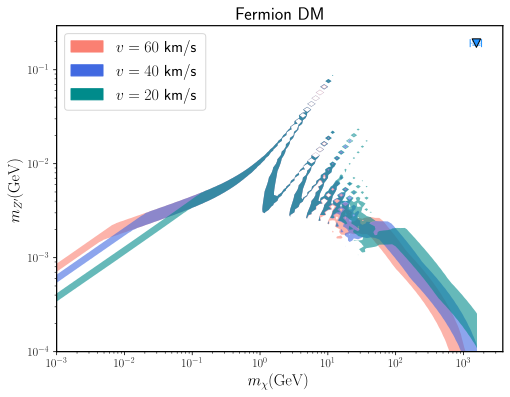

In [ ]:
g_p = 100 #Grid Points
M_l = np.logspace(-4, -1, g_p)
m_l = np.logspace(-3, 3.2, g_p)

#Grids
M_g, m_g = np.meshgrid(M_l, m_l)
sigma_grid_dwarf = np.zeros((g_p, g_p))
sigma_grid_clusters = np.zeros((g_p, g_p))
sigma_grid_all = np.zeros((g_p, g_p))

levels_dw=[30, 100]
levels_cl=[30, 100]
levels_al=[30,100]
fig, ax = plt.subplots(figsize=(8,6))
#ax = ax.ravel()
 
fig_index = 0

patch_dw1 = mpatches.Patch(color='salmon', label=r'$v=60$ km/s')
patch_dw2 = mpatches.Patch(color='royalblue', label=r'$v=40$ km/s')
patch_dw3 = mpatches.Patch(color='darkcyan', label=r'$v=20$ km/s')

alpha=0.012

mchi=pd.read_csv("Parameters/xsecvalpha_Mchi.csv", sep = ' ') 
mphi=pd.read_csv("Parameters/xsecvalpha_Mphi.csv", sep = ' ') 


mchim=mchi.iloc[0,:3]
mphim=mphi.iloc[0,:3]

for i in range(g_p):
    for j in range(g_p):
        sigma_grid_dwarf[i, j] = sigmaF(alpha, m_l[i], M_l[j],60*np.sqrt(np.pi)/4)
        sigma_grid_all[i, j] = sigmaF(alpha, m_l[i], M_l[j],40*np.sqrt(np.pi)/4)
        sigma_grid_clusters[i, j] = sigmaF(alpha, m_l[i], M_l[j],20*np.sqrt(np.pi)/4)

        
plt.errorbar(mchim[0], (mphim[0])*1e-3, yerr = (mphim[0]-mphim[2])*1e-3, xerr = (mchim[0]-mchim[2]), capsize=4, capthick=1.0, color='dodgerblue',\
                    fmt="v",markersize=8.5,linewidth=0.5,mec='black')

    #ax.fill_between(m_l, M_l[0], 1e-2, color=Gray1, alpha=0.5) 
plt.contourf(m_g, M_g, sigma_grid_dwarf, levels_dw, colors=('salmon',),alpha=0.6)
plt.contourf(m_g, M_g, sigma_grid_all, levels_cl, colors=('royalblue',),alpha=0.6)
plt.contourf(m_g, M_g, sigma_grid_clusters, levels_al, colors=('darkcyan',),alpha=0.6)

plt.xlabel('$m_{\chi} (\mathrm{GeV} )$', fontsize=16 )
plt.ylabel('$m_{Z\'} (\mathrm{GeV} )$',fontsize=16 )
plt.xscale('log')
plt.yscale('log')
plt.legend(handles=[patch_dw1, patch_dw2, patch_dw3], loc='upper left',fontsize=16)
plt.title(r'Fermion DM', fontsize=18)

fig_index +=1